# Reproducing experiment 6.2 from Tramdag paper

In [1]:
import os
# from tramdag.utils.configuration import *

from tramdag import TramDagConfig
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")
cfg=TramDagConfig()
cfg.setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/configuration.json


Setting seed: 42
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 MB
Train size: 80000, Validation size: 10000, Test size: 10000


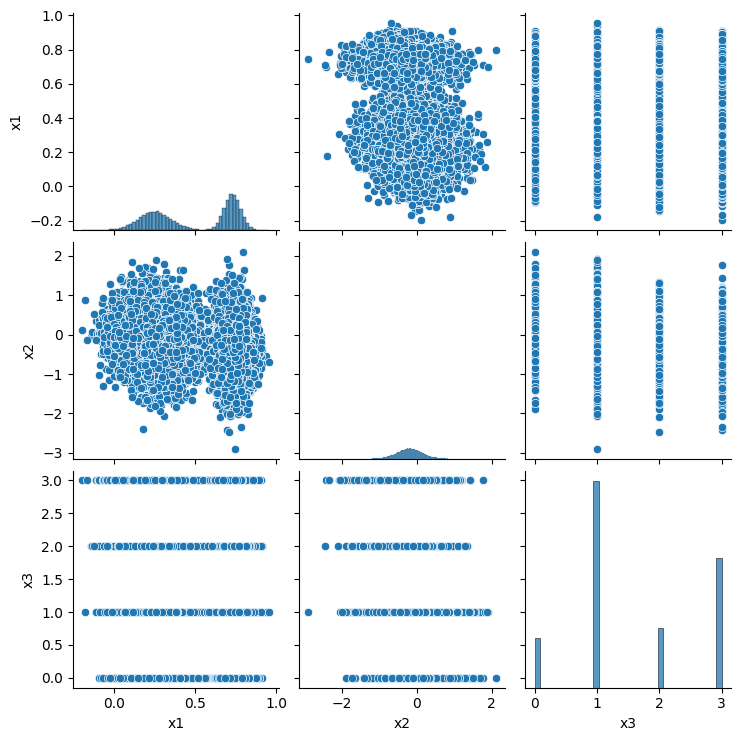

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 0
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[0, 1, 2, 3], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[0, 1, 2, 3],
            ordered=True
        )
        
    # x3 = x3.astype(float) / 4.0
    x3 = x3.astype(int) 
    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

df = dgp(n_obs=100_000, seed=42)
df.info()
sns.pairplot(df)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


In [4]:
data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yo'} 
cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/configuration.json.


/home/bule/TramDag/tramdag/utils/configuration.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


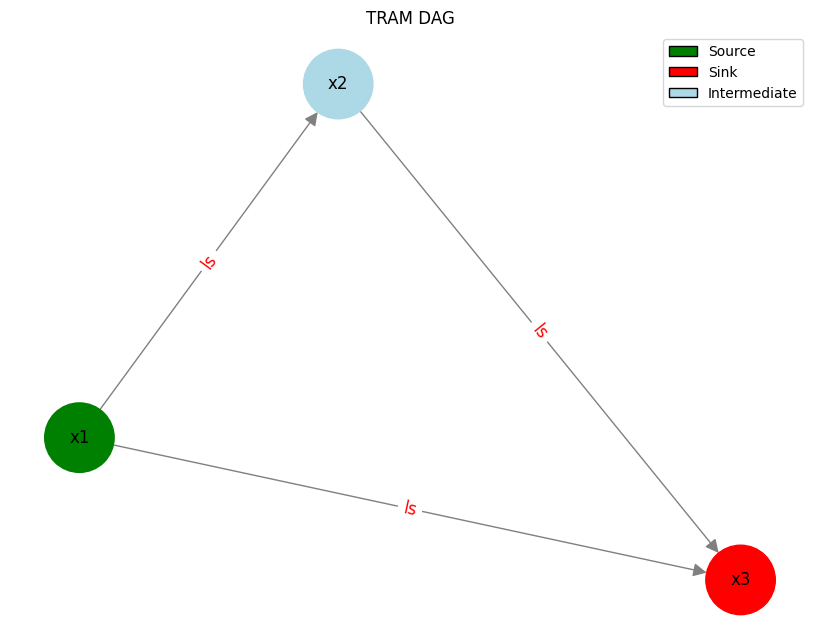

In [5]:
cfg.set_tramdag_terms()



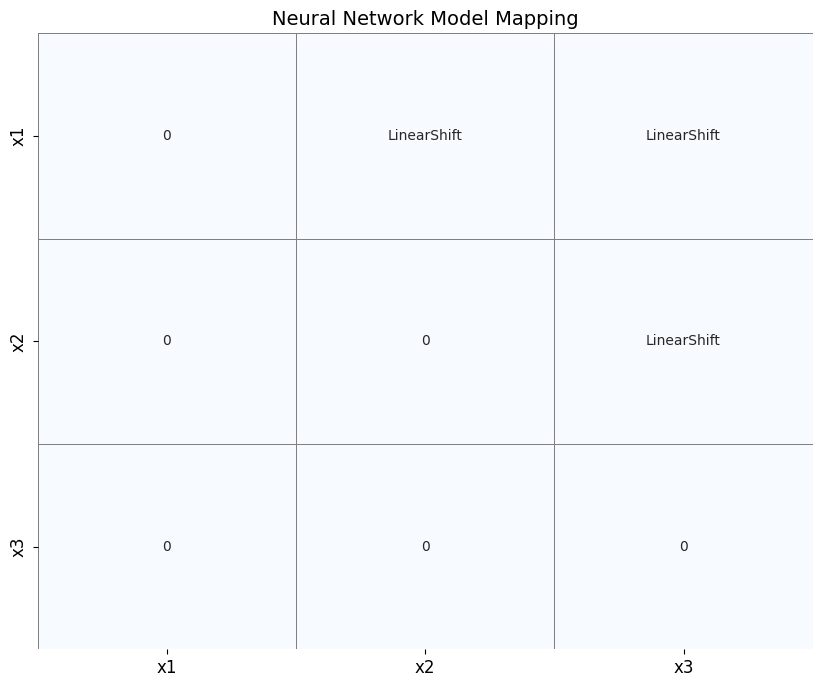

In [6]:
cfg.set_tramdag_nn_models()

# Model training & sampling

In [7]:
from tramdag import TramDagModel

cfg.compute_levels(train_df)
device='cpu'

In [8]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data = train_df) 


In [9]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=150,batch_size=1000,
             verbose=False,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

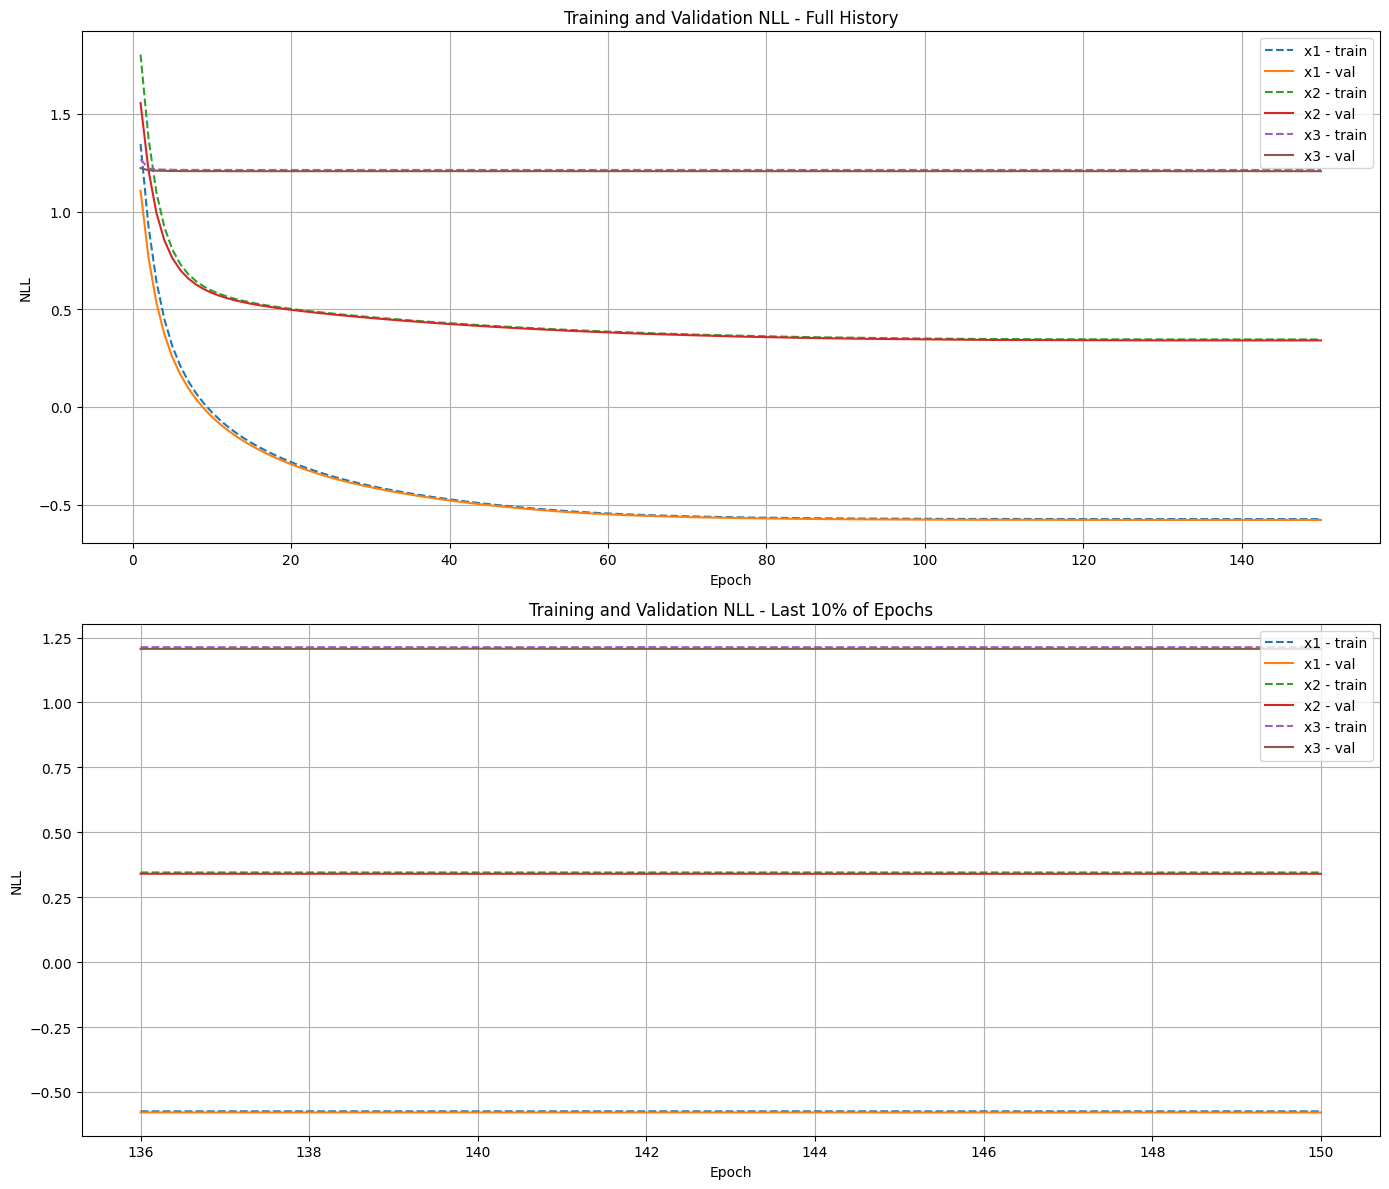

In [10]:
td_model.plot_loss_history()

```
  Continuous Outcome Logistic Regression 

Call:
Colr(formula = x2 ~ x1, data = data_6_2)

Coefficients:
      x1 
1.973891 

Log-Likelihood:
 -31293.99 (df = 8)
```
---------------------------------------------------
```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 
```

[WARNING] No linear shift history found for node 'x1' at /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x1/linear_shifts_all_epochs.json


/home/bule/TramDag/tramdag/TramDagModel.py:917: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


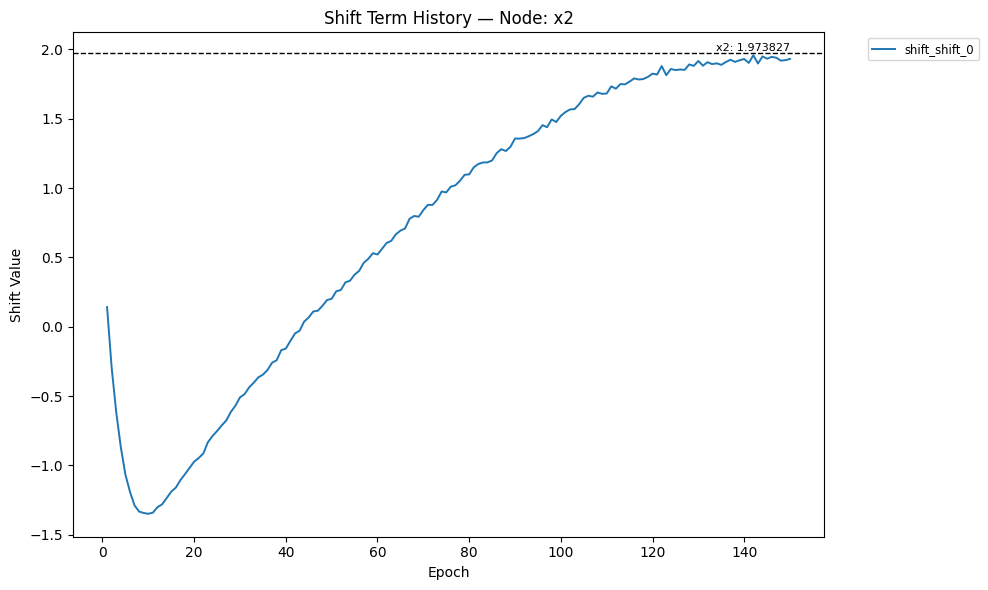

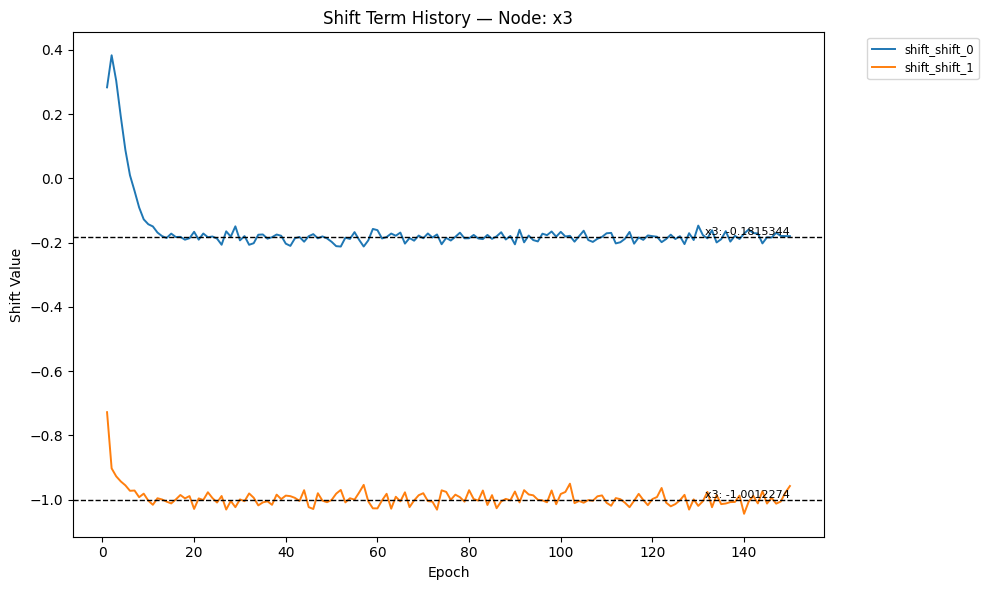

In [11]:
td_model.plot_linear_shift_history(ref_lines={'x2':[1.973827],'x3':[-0.1815344, -1.0012274 ]}) 

```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 

# Intercepts:
#       0|1       1|2       2|3 
# -1.998953  0.426397  1.032376 

# Residual Deviance: 194022.51 
# AIC: 194032.51 
```

/home/bule/TramDag/tramdag/TramDagModel.py:974: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


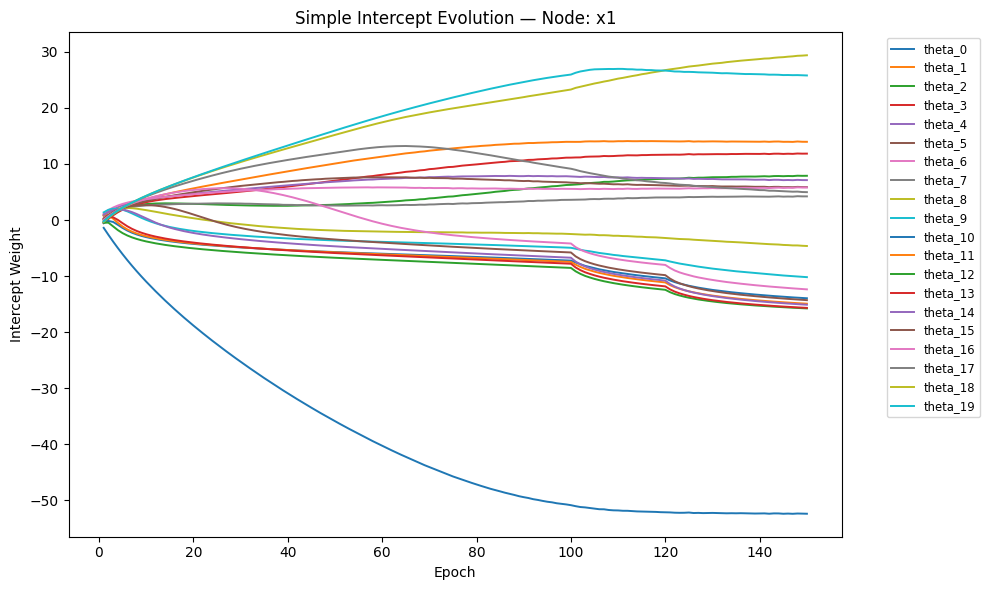

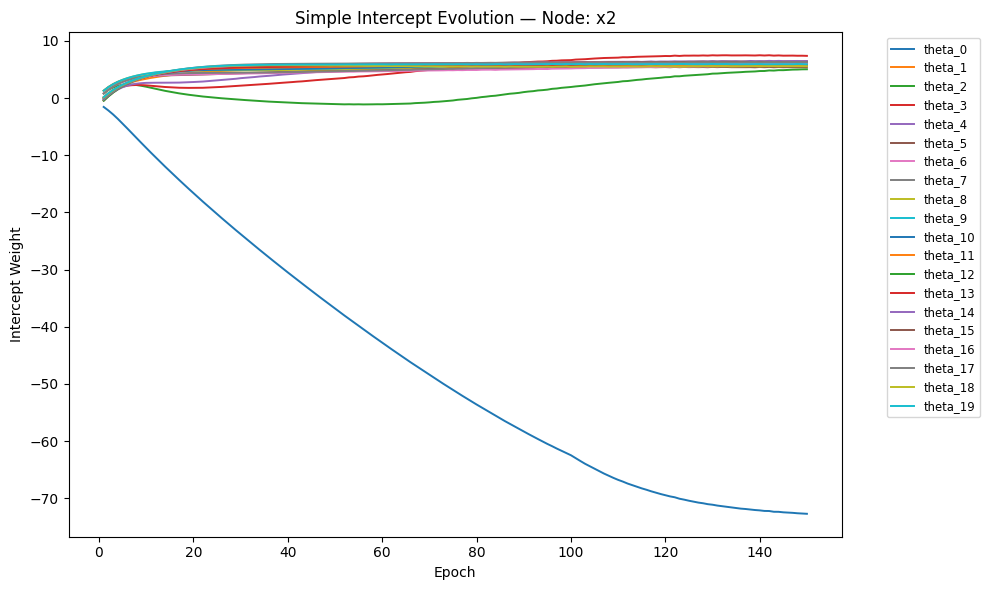

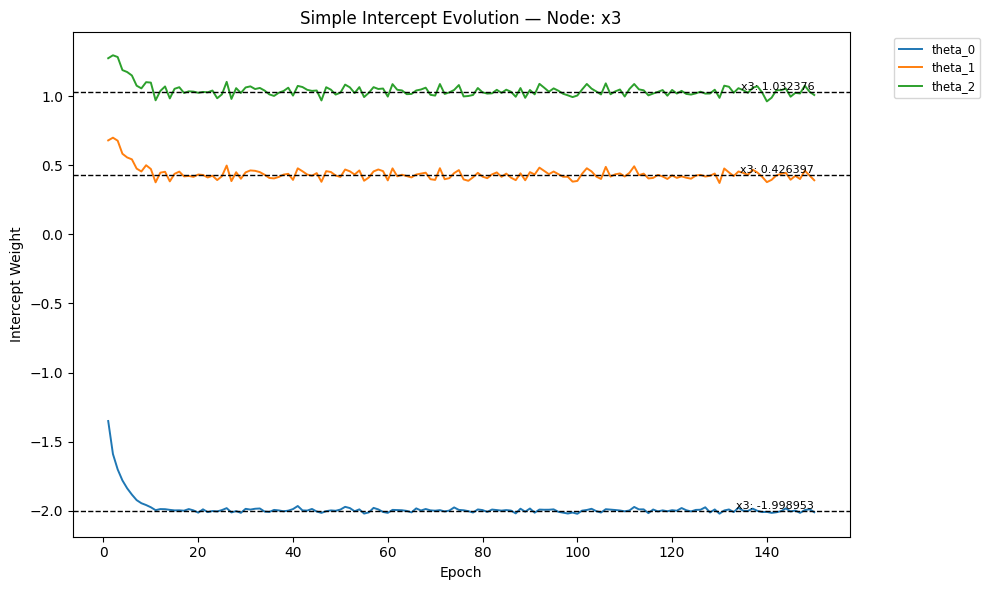

In [12]:
# [-2.054361   0.3095475  0.897935 ]

td_model.plot_simple_intercepts_history(ref_lines={'x3':[-1.998953,  0.426397,  1.032376]})

Deleted directory: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations::   0%|          | 0/100 [00:00<?, ?it/s]

[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.79it/s]


----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.16it/s]


----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?


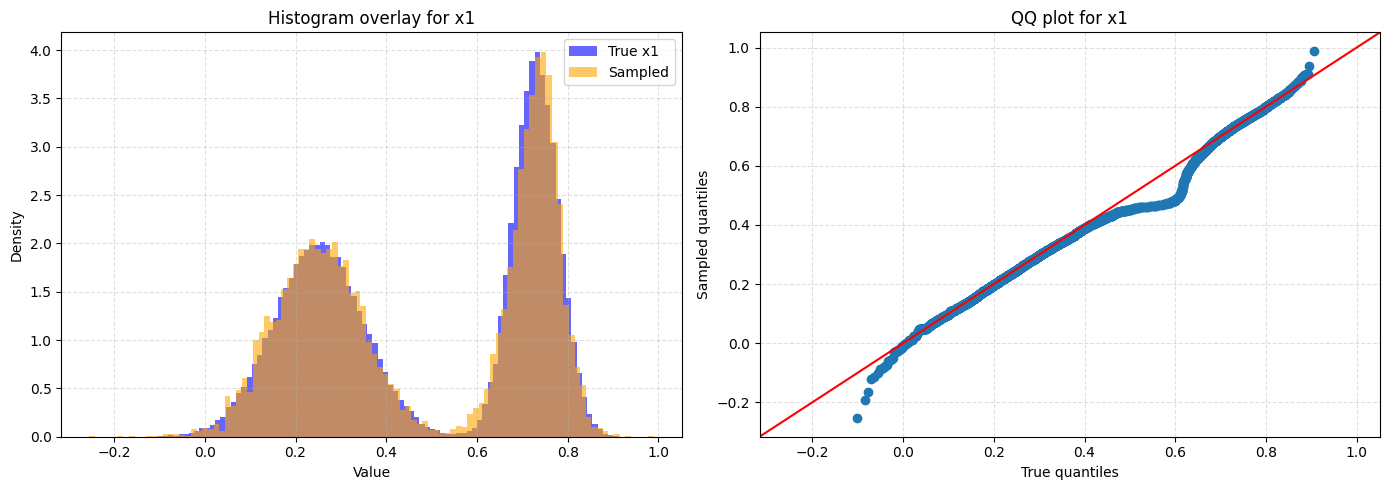

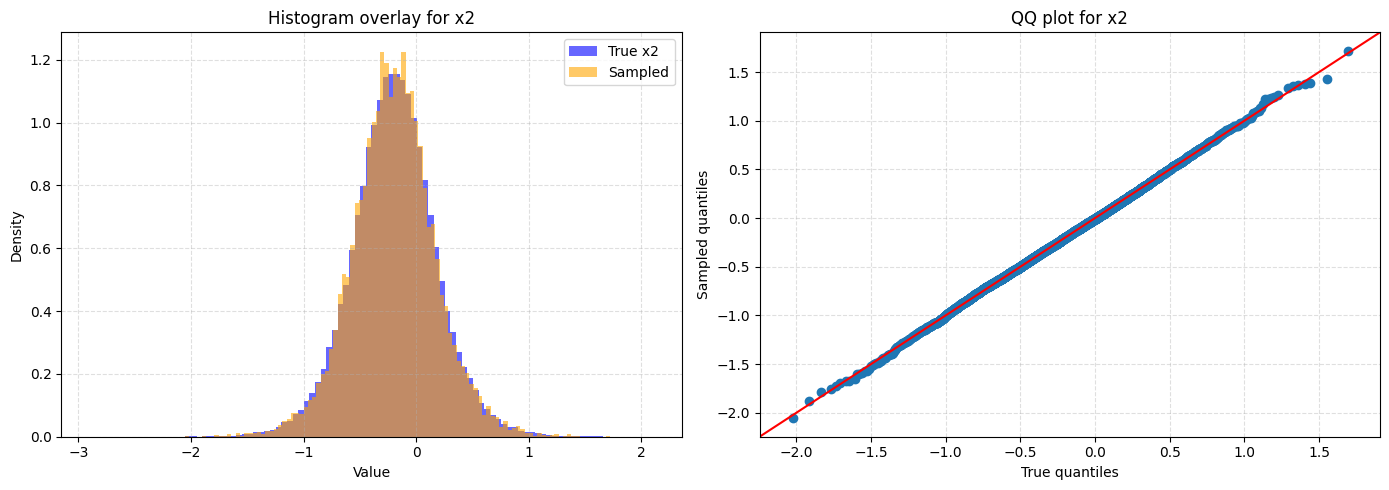

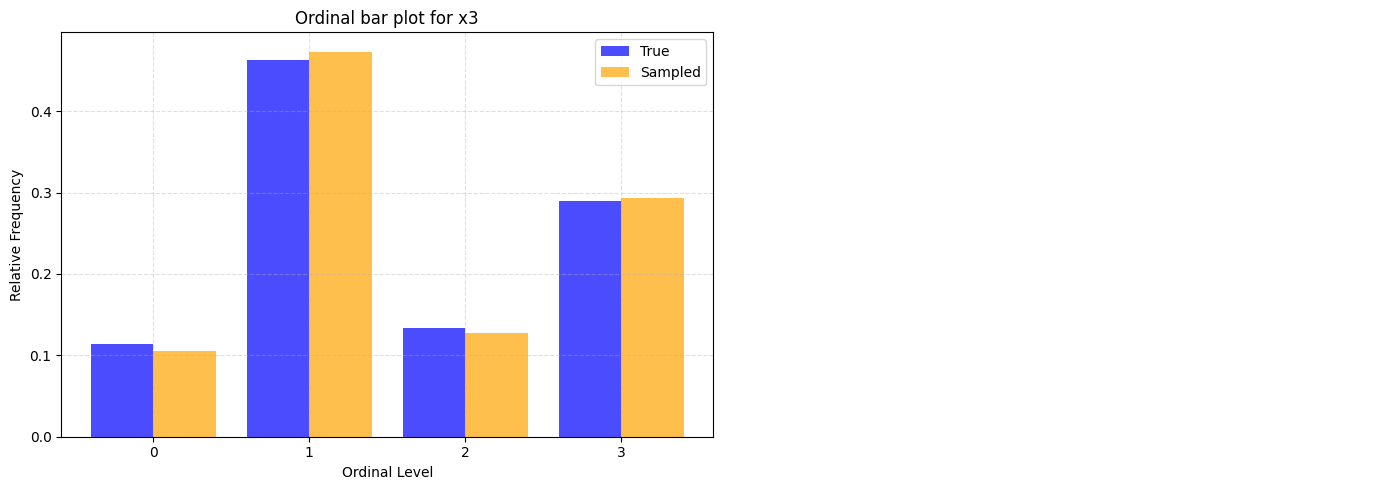

In [13]:
rsamples, latents = td_model.sample()
td_model.plot_samples_vs_true(train_df)

Deleted directory: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.87it/s]


----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?


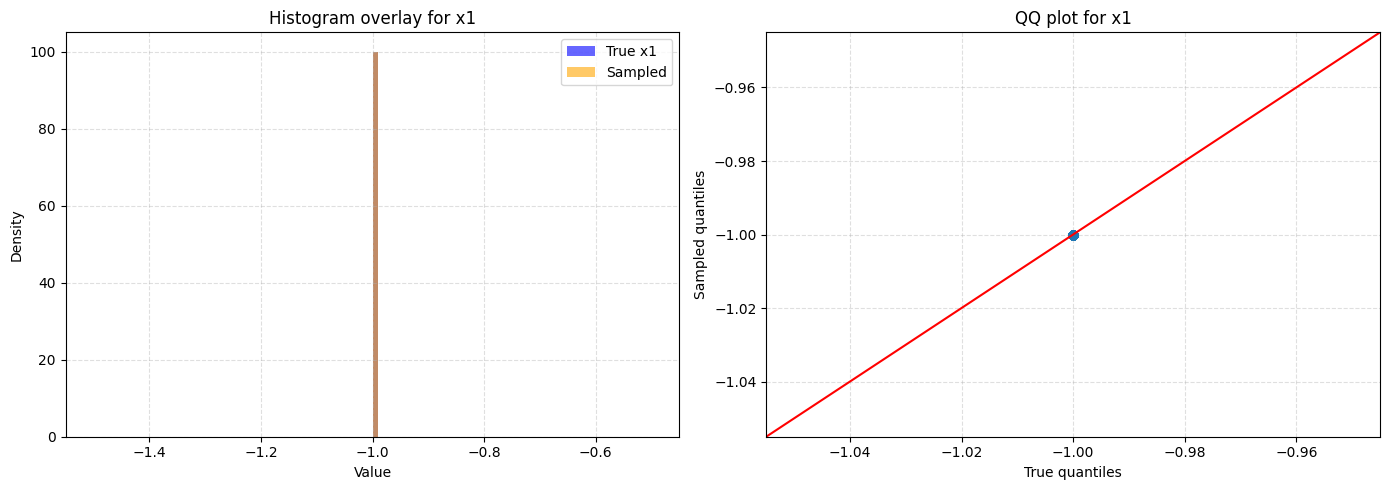

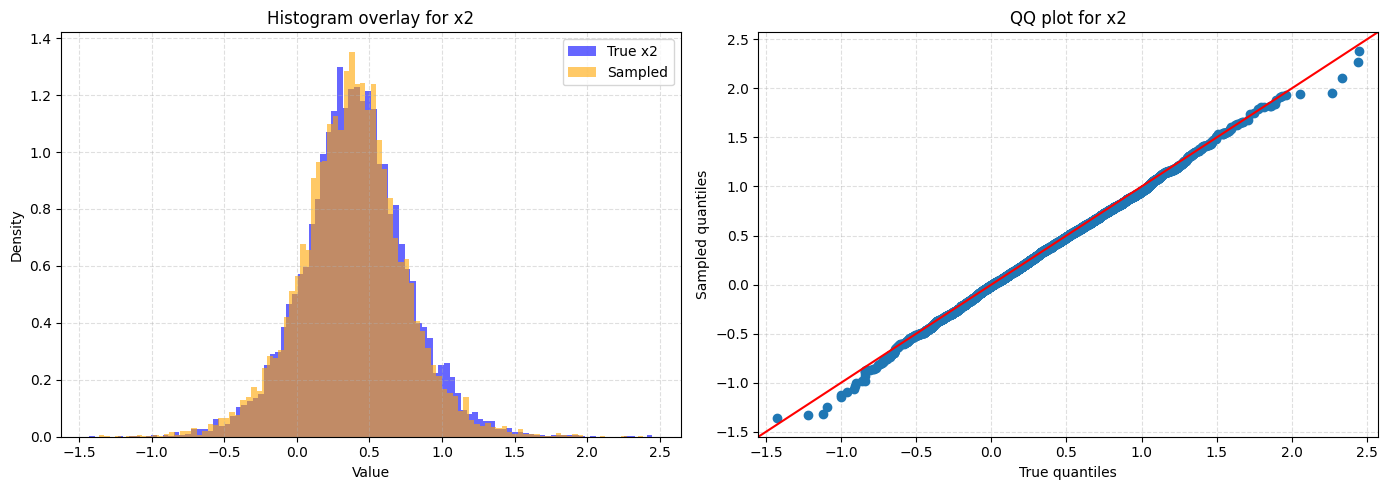

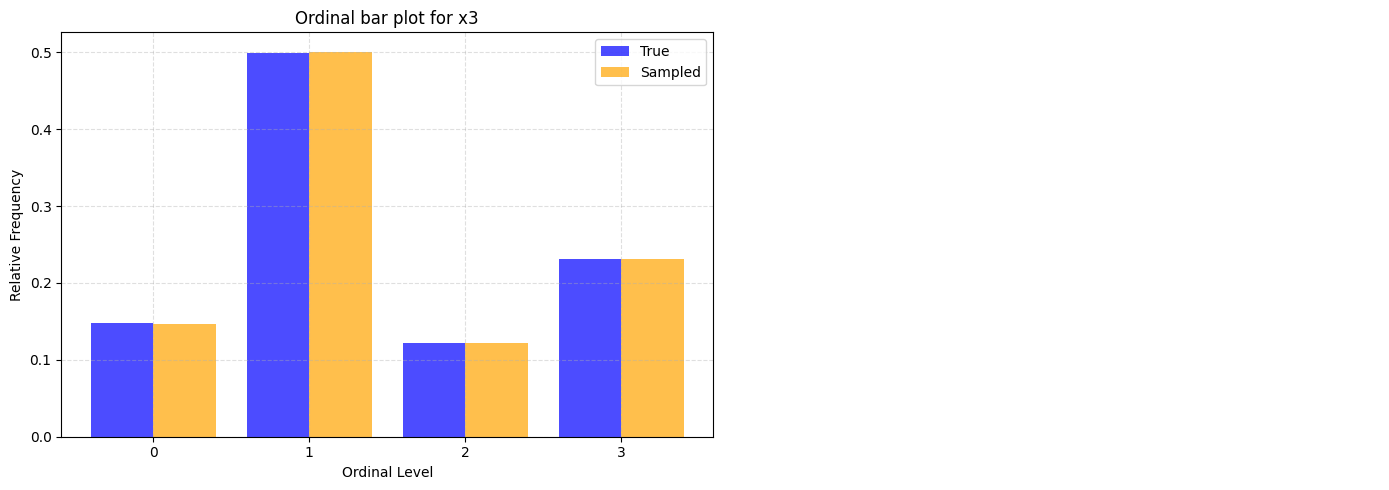

In [14]:
rsamples, latents = td_model.sample(do_interventions={'x1':-1.0})
inter_df=dgp(n_obs=10_000, doX=[-1.0,None , None])
td_model.plot_samples_vs_true(inter_df)

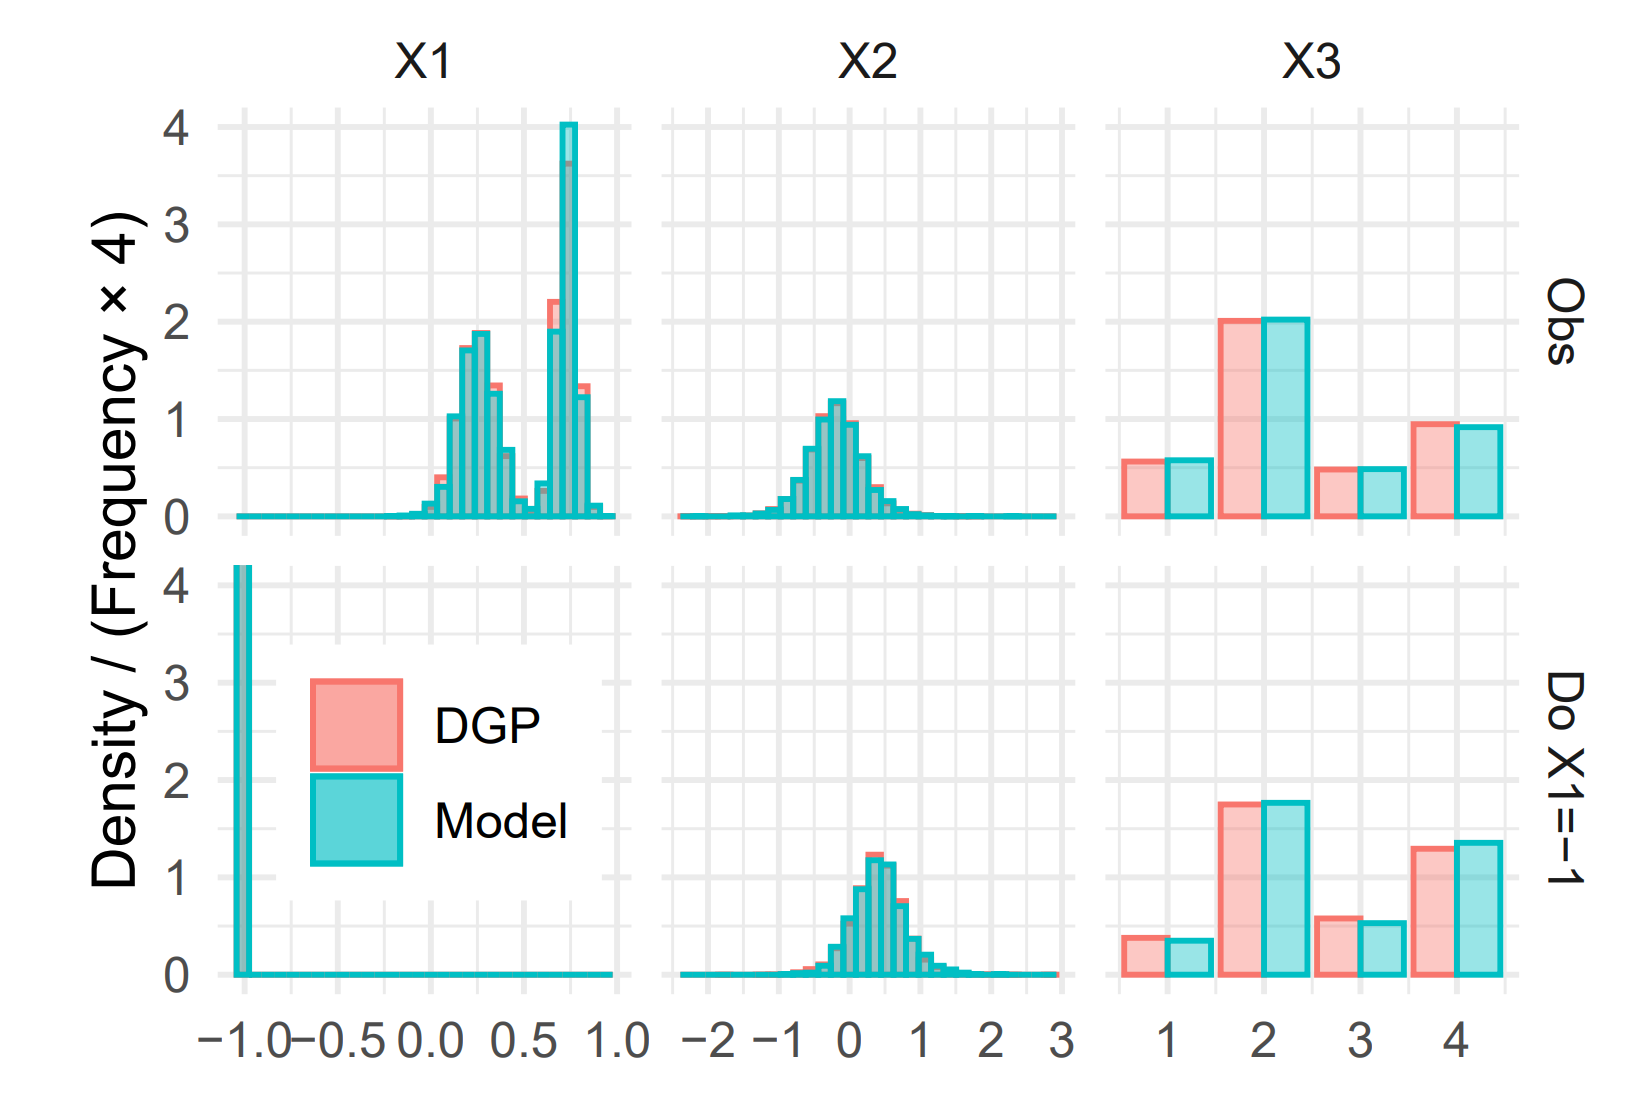

In [15]:
def linear_shifts_from_model(state='best'):
    nodes_list = list(self.models.keys())
    
    linear_shift_dict={}
    for node in nodes_list:
        EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
        NODE_DIR = os.path.join(EXPERIMENT_DIR, f"{node}")
        BEST_MODEL_PATH, LAST_MODEL_PATH, _, _ = model_train_val_paths(NODE_DIR)
        
        if state=='best':
            LOAD_PATH=BEST_MODEL_PATH
        elif state=='last':
            LOAD_PATH=LAST_MODEL_PATH
        
        
        state_dict = torch.load(LOAD_PATH, map_location=device)
        tram_model=self.models[node]
        tram_model.load_state_dict(state_dict)


        if  hasattr(tram_model, "nn_shift") and tram_model.nn_shift is not None:
        epoch_weights = {}
        for i, shift_layer in enumerate(tram_model.nn_shift):
            if hasattr(shift_layer, "fc") and hasattr(shift_layer.fc, "weight"):
                epoch_weights[f"shift_{i}"] = shift_layer.fc.weight.detach().cpu().tolist()
            else:
                if self.debug:
                    print(f"[DEBUG] shift_{i}: 'fc' or 'weight' not found.")
                    
        linear_shift_dict[node]=epoch_weights
    return linear_shift_dict

IndentationError: expected an indented block (4020555367.py, line 22)

In [16]:
td_model.linear_shifts_from_model()

{'x2': {'shift_0': [[1.9482349157333374]]},
 'x3': {'shift_0': [[-0.17996762692928314]],
  'shift_1': [[-1.0232107639312744]]}}

In [ ]:
td_model.models

{'x1': TramModel(
   (nn_int): SimpleIntercept(
     (fc): Linear(in_features=1, out_features=20, bias=False)
   )
 ),
 'x2': TramModel(
   (nn_int): SimpleIntercept(
     (fc): Linear(in_features=1, out_features=20, bias=False)
   )
   (nn_shift): ModuleList(
     (0): LinearShift(
       (fc): Linear(in_features=1, out_features=1, bias=False)
     )
   )
 ),
 'x3': TramModel(
   (nn_int): SimpleIntercept(
     (fc): Linear(in_features=1, out_features=3, bias=False)
   )
   (nn_shift): ModuleList(
     (0-1): 2 x LinearShift(
       (fc): Linear(in_features=1, out_features=1, bias=False)
     )
   )
 )}